In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [3]:
df= pd.read_csv('./data/protein_foods.csv' ,index_col = 'code')

In [4]:
df.describe()

,agriculture,transformation,packaging,transport,supermarket_distribution,consumption,total
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,8.338617,0.304022,0.288451,0.441349,0.037556,0.019629,9.429624
std,8.759344,0.366531,0.079809,0.368739,0.009065,0.049335,8.683987
min,0.015850,0.000000,0.000000,0.056411,0.016099,0.000000,0.419522
25%,4.362845,0.000000,0.262661,0.211504,0.035574,0.006688,5.224935
50%,5.236728,0.254544,0.275642,0.211504,0.036974,0.006688,6.206461
75%,8.760654,0.392871,0.275642,0.787359,0.036974,0.006688,10.839679
max,40.546904,2.112212,0.739966,1.365207,0.147055,0.449154,41.346947


## Fit the standard scaler to the data, and then transform the data using that scaler

In [5]:
# Reshape 'total' column to a 2-dimensional array
total_values = df['total'].values.reshape(-1, 1)

# Create and fit the MinMaxScaler to scale the 'total' column
scaler=StandardScaler()
df['total_t'] = scaler.fit_transform(total_values)
df['total_t'] = df['total_t'].values.reshape(-1, 1)


In [8]:
df.head(3)

,product,food subgroup,lci name,preparation,agriculture,transformation,packaging,transport,supermarket_distribution,consumption,total,total_t
code,,,,,,,,,,,,
30352,beef,deli meats,"salami, pork and beef",no preparation,5.151833,0.642781,0.098457,0.204987,0.037393,0.006688,6.142138,-0.379103
30152,beef,deli meats,"merguez sausage, pure beef, raw",no preparation,29.803955,0.117971,0.277614,0.209765,0.037393,0.006688,30.453386,2.424397
30153,beef,deli meats,"merguez sausage, pork and beef, raw",no preparation,23.726495,0.515156,0.481567,0.213340,0.037393,0.006688,24.980639,1.793297


## Identifying optimum number of clusters

The method are we going to use is Elbow method.

In [22]:
# Create a function to work out optimum number of clusters


def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range (1, max_k):       
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    
#Generate the elbow plot

    fig = plt.subplots(figsize= (10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

C:\Users\Pierre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pierre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pierre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pierre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

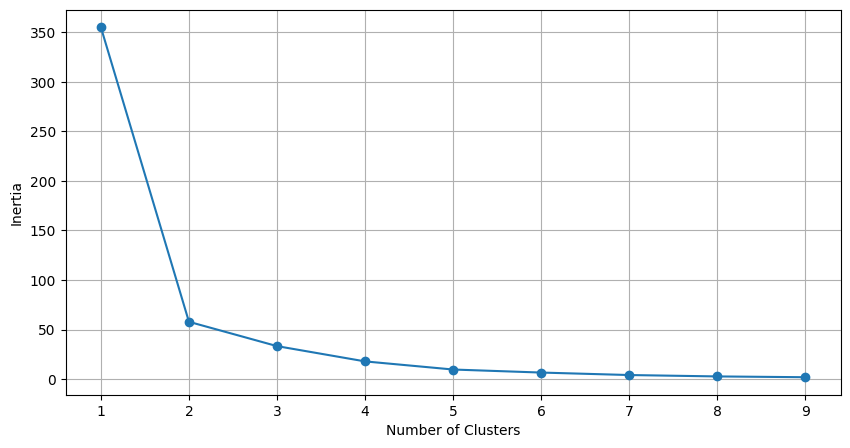

In [10]:
optimise_k_means(df['total_t'].values.reshape(-1, 1), 10)

## 1 Applying K Means Clustering

In [12]:
kmeans= KMeans(n_clusters = 4)

In [13]:
kmeans.fit(df['total_t'].values.reshape(-1, 1))

C:\Users\Pierre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [14]:
df['kmeans'] = kmeans.labels_

In [15]:
df.head(3)

,product,food subgroup,lci name,preparation,agriculture,transformation,packaging,transport,supermarket_distribution,consumption,total,total_t,kmeans
code,,,,,,,,,,,,,
30352,beef,deli meats,"salami, pork and beef",no preparation,5.151833,0.642781,0.098457,0.204987,0.037393,0.006688,6.142138,-0.379103,0
30152,beef,deli meats,"merguez sausage, pure beef, raw",no preparation,29.803955,0.117971,0.277614,0.209765,0.037393,0.006688,30.453386,2.424397,3
30153,beef,deli meats,"merguez sausage, pork and beef, raw",no preparation,23.726495,0.515156,0.481567,0.213340,0.037393,0.006688,24.980639,1.793297,3


## 2 Quantile-based binning

This function will categorize the products into four groups based on the distribution of their total values. Products with lower footprint values will fall into group 1, while those with the highest values will fall into group 4.

In [16]:
#Use qcut to devide the 'total' column into 4 quantiles
df['quantile']= pd.qcut(df['total_t'], q=4,
                    labels = [1,2,3,4])

df.head()

,product,food subgroup,lci name,preparation,agriculture,transformation,packaging,transport,supermarket_distribution,consumption,total,total_t,kmeans,quantile
code,,,,,,,,,,,,,,
30352,beef,deli meats,"salami, pork and beef",no preparation,5.151833,0.642781,0.098457,0.204987,0.037393,0.006688,6.142138,-0.379103,0,2
30152,beef,deli meats,"merguez sausage, pure beef, raw",no preparation,29.803955,0.117971,0.277614,0.209765,0.037393,0.006688,30.453386,2.424397,3,4
30153,beef,deli meats,"merguez sausage, pork and beef, raw",no preparation,23.726495,0.515156,0.481567,0.213340,0.037393,0.006688,24.980639,1.793297,3,4
30154,beef,deli meats,"merguez sausage, beef, mutton and pork, raw",no preparation,31.371255,0.322086,0.378726,0.211707,0.037393,0.006688,32.327855,2.640556,1,4
30156,beef,deli meats,"merguez sausage, beef and mutton, raw",no preparation,38.887532,0.132261,0.277614,0.210101,0.037393,0.006688,39.551589,3.473575,1,4


## Compare the kmeans with the quantiles clustering

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(12, 6))

# One-dimensional Scatter plot for Kmeans clusters
plt.subplot(1, 2, 1)   # 1, 2, 1  => rows, columns, index
sns.stripplot(x=df['kmeans'], y=df['total_t'], jitter=0.4, alpha=0.7, palette='Set2')
plt.ylabel('Total Carbon Footprint')
plt.xlabel('Kmeans')

# One -dimensional Scatter plot for quantiles clusters
plt.subplot(1, 2, 2)
sns.stripplot(x=df['quantile'], y=df['total_t'], jitter=0.4, alpha=0.7, palette='Set2')
plt.ylabel('Total Carbon Footprint')
plt.xlabel('Quantiles')

plt.tight_layout()

# Save the figure as a PNG image
plt.savefig('scatter_plots.png', dpi=300)

plt.close()  # Close the figure to prevent displaying it in the notebook


C:\Users\Pierre\AppData\Local\Temp\ipykernel_13040\1420581641.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df['kmeans'], y=df['total_t'], jitter=0.4, alpha=0.7, palette='Set2')
C:\Users\Pierre\AppData\Local\Temp\ipykernel_13040\1420581641.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df['quantile'], y=df['total_t'], jitter=0.4, alpha=0.7, palette='Set2')


###  Change the values of the kmeans to the correspondent ones

In [13]:
df['kmeans'] = df['kmeans'].replace({2:1, 0:2, 1:3, 3:4})

### Rename columns

In [14]:
df.rename(columns={'product':'SOURCE', 'food subgroup' : 'GROUP', 'lci name': 'PRODUCT', 'agriculture':'AGRICULTURE',
                     'transformation':'TRANSFORMATION', 'packaging':'PACKAGING', 'transport':'TRANSPORT','supermarket_distribution': 'SUPERMARKET AND DISTRIBUTION',
                    'consumption': 'CONSUMPTION', 'total': 'TOTAL IMPACT', 'kmeans': 'LEVEL'}, inplace=True)

In [15]:
data = df.drop(columns=['preparation', 'total_t', 'quantile'])

In [16]:
data

,SOURCE,GROUP,PRODUCT,AGRICULTURE,TRANSFORMATION,PACKAGING,TRANSPORT,SUPERMARKET AND DISTRIBUTION,CONSUMPTION,TOTAL IMPACT,LEVEL
code,,,,,,,,,,,
30352,beef,deli meats,"salami, pork and beef",5.151833,0.642781,0.098457,0.204987,0.037393,0.006688,6.142138,1
30152,beef,deli meats,"merguez sausage, pure beef, raw",29.803955,0.117971,0.277614,0.209765,0.037393,0.006688,30.453386,3
30153,beef,deli meats,"merguez sausage, pork and beef, raw",23.726495,0.515156,0.481567,0.213340,0.037393,0.006688,24.980639,3
30154,beef,deli meats,"merguez sausage, beef, mutton and pork, raw",31.371255,0.322086,0.378726,0.211707,0.037393,0.006688,32.327855,4
30156,beef,deli meats,"merguez sausage, beef and mutton, raw",38.887532,0.132261,0.277614,0.210101,0.037393,0.006688,39.551589,4
...,...,...,...,...,...,...,...,...,...,...,...
12763,cheese,cheeses,tomme cheese (pdo) from the french bauges munn...,5.008959,0.231282,0.262661,0.211504,0.035574,0.006688,5.756667,1
12759,cheese,cheeses,"tomme cheese, from mountain or savoy",4.928558,0.235755,0.262661,0.211504,0.035574,0.006688,5.680739,1
12758,cheese,cheeses,"tomme cheese, from cow's milk",4.975453,0.233518,0.262661,0.211504,0.035574,0.006688,5.725397,1


In [17]:
data.to_csv('./data/clustered_products.csv')